# Frequency and time-frequency sensors analysis


The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

    Authors: Marijn van Vliet, Britta Westner, Alexandre Gramfort, Stefan Appelhoff, Richard Höchenberger, Denis A. Engemann

## Setup

You already know this from the last part

In [1]:
# This makes figures appear inside the notebook instead of in a new window.
%matplotlib inline

# These are the Python packages we will use in this notebook.
import numpy as np  # for numerical computations
import matplotlib.pyplot as plt  # for making custom figures
import mne  # for MEG and EEG data analysis

mne.set_log_level('warning')

As before, we again set our paths. Then we load the epochs data we have saved.


In [2]:
# Change the following path to where the folder ds000117 is on your disk.
data_path = "./ds000117_pruned"  # `./` means the folder of this notebook

# Based on the `data_path` you specified above, and assuming you have completed the previous notebook,
# this is where the raw MEG+EEG data should be.
epochs_fname = f"{data_path}/derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-epo.fif"
epochs = mne.read_epochs(epochs_fname)

In [3]:
epochs

<EpochsFIF | 79 events (all good), -0.467 – 2.033 s (baseline -0.2 – 0 s), ~178.0 MiB, data loaded,
 'face/famous/first': 13
 'face/famous/immediate': 3
 'face/famous/long': 6
 'face/unfamiliar/first': 17
 'face/unfamiliar/immediate': 4
 'face/unfamiliar/long': 6
 'scrambled/first': 15
 'scrambled/immediate': 9
 'scrambled/long': 6>

Frequency analysis
------------------

We start by exploring the frequency content of our epochs.



Let's first check out the power spectrum of the different channel types by averaging across epochs.

<li> The "bandwidth" parameter controls the spectral resolution of the multitaper. You can increase the resolution by chosing a narrower bandwidth at the cost of longer computation time.</li>
<li> You can also set method to `'welch'`, which will compute a power spectrum without using multi tapers.</li>


In [4]:
# Let's first compute the power spectrum

epochs_psd = epochs.compute_psd(method='multitaper', fmin=2., fmax=40., bandwidth=2.)

In [5]:
epochs_psd

<Power Spectrum (from Epochs, multitaper method) | 79 epochs × 376 channels × 95 freqs, 2.4-39.9 Hz>

In [9]:
# Fit a sphere to the digitized EEG points for better topomap plots.
radius, center, _ = mne.bem.fit_sphere_to_headshape(epochs.info, dig_kinds="eeg")
sphere = tuple(center) + (radius,)

In [10]:
%matplotlib qt
epochs_psd.plot(sphere=sphere);

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> What is the name of the EEG channel with the highest power at high frequencies?</li>
    <li> What do the topographies at (roughly) 8-12 Hz look like?</li>
    </ul>
</div>

We can also look at the topographies of this power spectrum, e.g. for different frequency bands. Here, we have to specify a channel type!

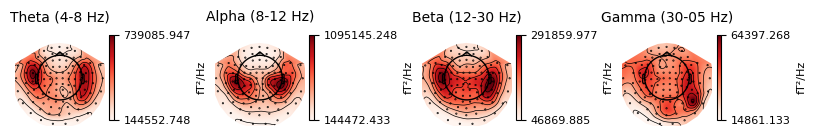

In [14]:
%matplotlib inline
bands = {'Theta (4-8 Hz)': (4, 8), 'Alpha (8-12 Hz)': (8, 12), 
         'Beta (12-30 Hz)': (12, 30), 'Gamma (30-05 Hz)': (30, 40)}
epochs_psd.plot_topomap(ch_type='mag', bands=bands, normalize=False, sphere=sphere);

The output of `compute_psd()` is a `Spectrum` object. We can index it similarly to `Epochs`.

Sometimes it can be interesting to consider the relative power, defined as the power in a given band divided by the total power. To explore this option, we can set the `normalize` parameter to `True`.

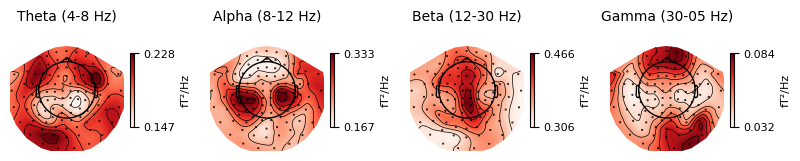

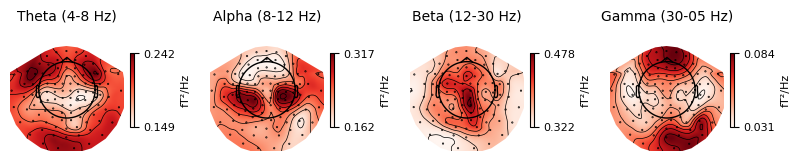

In [15]:
epochs_psd['face'].plot_topomap(ch_type='mag', bands=bands, normalize=True, sphere=sphere);
epochs_psd['scrambled'].plot_topomap(ch_type='mag', bands=bands, normalize=True, sphere=sphere);

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

In [17]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([5, 30]), num=20)
# decimate the signal by a factor of 3 for some additional speed
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=3, decim=3, n_jobs=1)

In [18]:
 # crop to remove edge artifacts
power.crop(-0.45, 1.6) 
itc.crop(-0.45, 1.6) 

Data type,Inter-trial coherence
Data source,Epochs
Number of epochs,376
Dims,"channel, freq, time"
Estimation method,morlet
Number of channels,376
Number of timepoints,206
Number of frequency bins,20
Frequency range,5.00 – 30.00 Hz


Inspect power
-------------

Let's look at the time-frequency spectra of all channels.


<div class="alert alert-info"><h4>Note</h4><p>The generated figure is interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



In [19]:
# Some setting for our baseline, which will be applied to the plots
baseline_mode = 'logratio' 
baseline = (-0.45, -0.1)

<div class="alert alert-info"><h4>Note</h4><p>Important! 
The baseline we work with is way too short for the low frequencies in our decomposition: <br>
For 5 Hz, or time window of 3 cycles are 600 ms long. This is already longer than our baseline! <br>
Plus, we chose only 100 ms of buffer towards 0: If we center the 5 Hz - 3 cycles wavelet at -100 ms, we reach 200 ms beyond 0, thus we will leak stimulus activity into our baseline: not good. <br>

So, what to do? <br>
In real life, we would re-cut the epochs to get more than 500 ms of baseline!
</p></div>

In [21]:
%matplotlib qt
power.plot_topo(baseline=baseline, mode=baseline_mode, title='Average power');

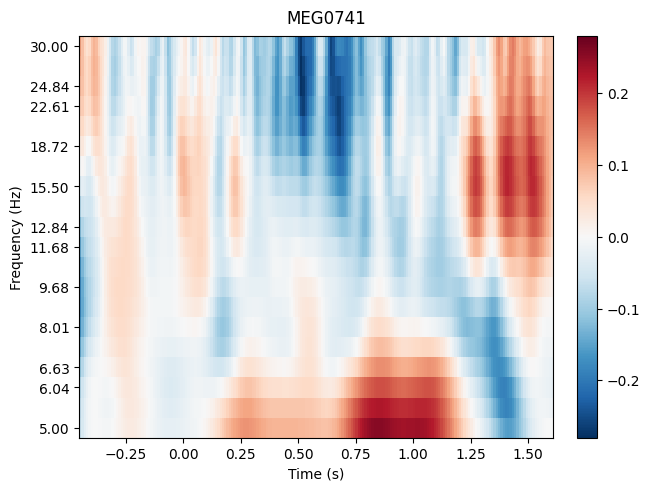

In [22]:
%matplotlib inline
power.plot([83], baseline=baseline, mode=baseline_mode, title=power.ch_names[83]);

We can look at topographies again - 

In [ ]:
power.plot_topo?

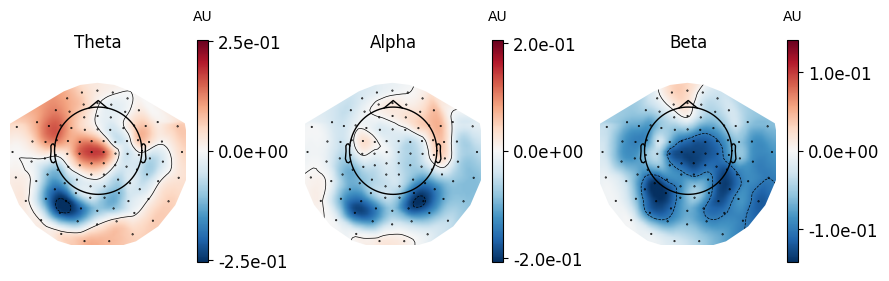

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
plot_freqs = [(4, 7), (8, 12), (15, 30)]
titles = ['Theta', 'Alpha', 'Beta']

for ax, freq, title in zip(axes, plot_freqs, titles):
    power.plot_topomap(ch_type='mag', tmin=0.5, tmax=1.0,
                   fmin=freq[0], fmax=freq[1],
                   baseline=baseline, mode=baseline_mode, 
                   axes=ax, show=False, contours=1, sphere=sphere)
    ax.set_title(title)
plt.tight_layout()
plt.show()

Joint Plot
----------
You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



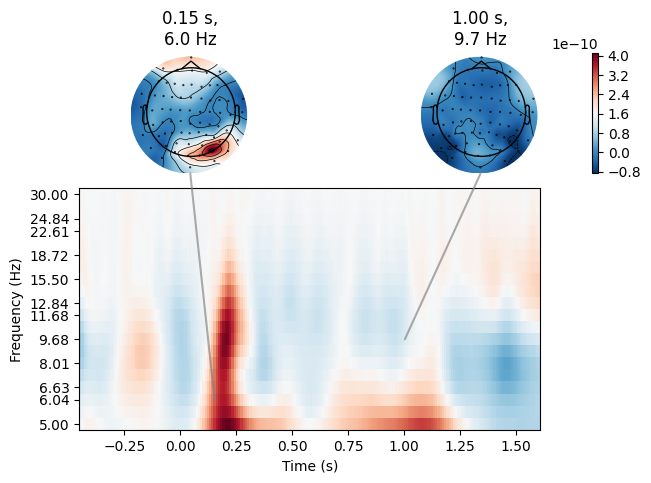

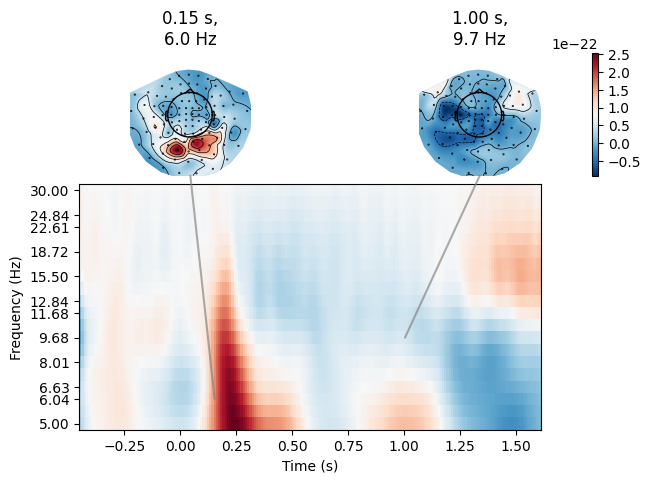

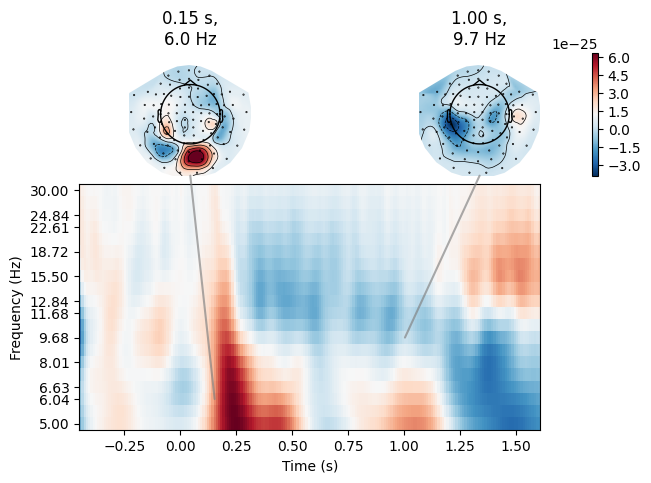

In [28]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.15, 6.), (1., 10.)], topomap_args=dict(sphere=sphere));

## Compute FWHM for our wavelets

We defined our wavelets based on _number of cycles_. Mike X Cohen (Cohen 2019, NeuroImage (199, p. 81-86)) argues that it is better to define the full-width-at-half-maximum (FWHM) of the Morlet wavelet.

You might remember that our wavelet of `n_cycles` gets multiplied with a Gaussian taper that dampens the wavelet towards the edges. Thus, the FWHM is a better estimate of the temporal smoothing than the full length of `n_cycles`.

Let's see how to do this:

In [29]:
# First let's check our cycles per frequency - we had specified them above:
freqs, n_cycles  # this is the number of cycles we asked for per frequency

(array([ 5.        ,  5.49446401,  6.03782696,  6.63492459,  7.29107088,
         8.01210531,  8.80444486,  9.67514109, 10.63194291, 11.68336555,
        12.83876631, 14.1084279 , 15.50364987, 17.03684926, 18.72167104,
        20.57310956, 22.60764202, 24.84337511, 27.3002061 , 30.        ]),
 3.0)

The formula to retrieve the FWHM is (Cohen 2019, eq. 4):

$ FWHM = \frac{n  \sqrt(2  \ln 2)}{\pi * f} \enspace,$

where $n$ is the number of cycles, $f$ is the frequency, and $\ln$ denotes the natural logarithm.

Let's convert this equation into a little function!

In [30]:
def get_fwhm_morlet(n_cycles, freq):
    """Estimate the FWHM of a Morlet wavelet."""

    fwhm = (n_cycles * np.sqrt(2 * np.log(2))) / (np.pi * freq)
    return fwhm


Now let's estimate what length of the FWHM of our Morlet wavelets was in seconds:

In [31]:
for freq in freqs:
    
    # estimate fwhm
    fwhm = get_fwhm_morlet(n_cycles, freq)

    # print it
    print('FWHM at %.3f Hz was %.3f s' % (freq, fwhm))

FWHM at 5.000 Hz was 0.225 s
FWHM at 5.494 Hz was 0.205 s
FWHM at 6.038 Hz was 0.186 s
FWHM at 6.635 Hz was 0.169 s
FWHM at 7.291 Hz was 0.154 s
FWHM at 8.012 Hz was 0.140 s
FWHM at 8.804 Hz was 0.128 s
FWHM at 9.675 Hz was 0.116 s
FWHM at 10.632 Hz was 0.106 s
FWHM at 11.683 Hz was 0.096 s
FWHM at 12.839 Hz was 0.088 s
FWHM at 14.108 Hz was 0.080 s
FWHM at 15.504 Hz was 0.073 s
FWHM at 17.037 Hz was 0.066 s
FWHM at 18.722 Hz was 0.060 s
FWHM at 20.573 Hz was 0.055 s
FWHM at 22.608 Hz was 0.050 s
FWHM at 24.843 Hz was 0.045 s
FWHM at 27.300 Hz was 0.041 s
FWHM at 30.000 Hz was 0.037 s


Inspect ITC
-----------



In [37]:
%matplotlib qt
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

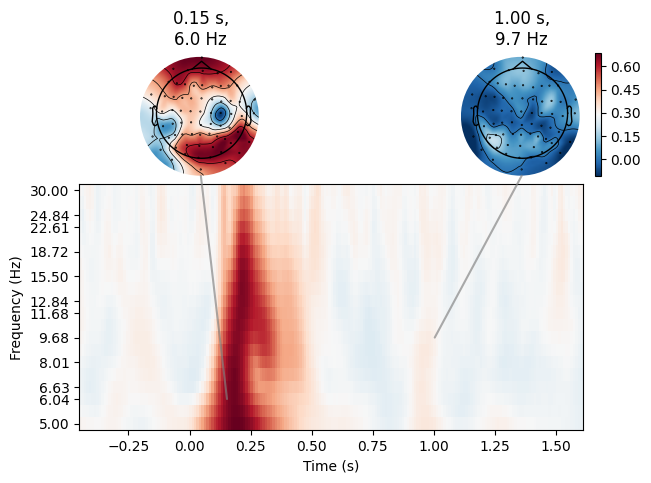

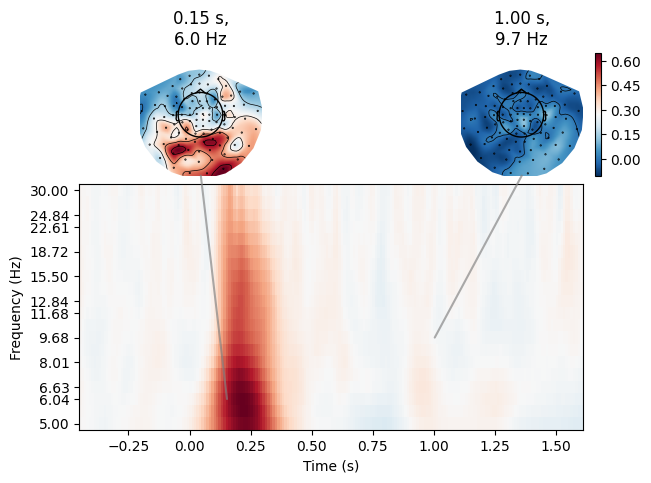

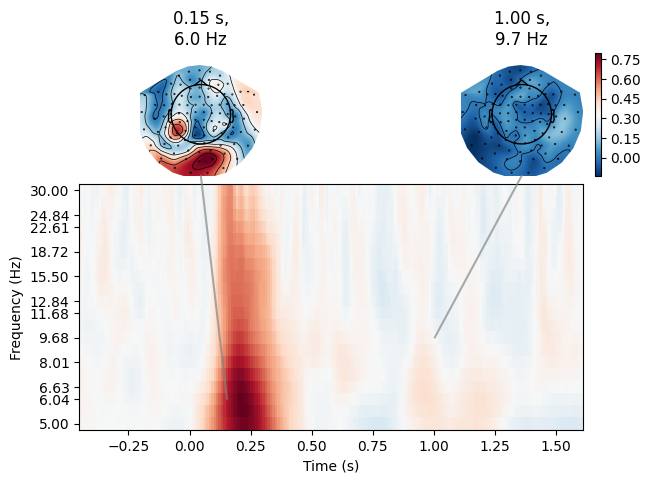

In [34]:
%matplotlib inline
itc.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.15, 6.), (1., 10.)], topomap_args=dict(sphere=sphere));